**FDA Drug Approval Feature Extaction - Language Models**

- Harvard Capstone: Fall 2024
- Date: 11/29/2024

## Imports

In [ ]:
# !pip install llmware
# !pip install openvino
# !pip install openvino_genai
# # Install spaCy and download the English language model if not already installed
# !pip install spacy
# !python -m spacy download en_core_web_sm
# pip install haystack-ai "transformers[torch,sentencepiece]"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import spacy
import re

from getpass import getpass

import torch
from transformers import pipeline
from haystack import Document
from haystack.components.readers import ExtractiveReader
import openai
from openai import OpenAI

pd.set_option('display.max_colwidth', 20)
%config InlineBackend.figure_format = 'retina'

# ANSI escape codes for colors and bold text
RED_BOLD = "\033[1;31m"
RESET = "\033[0m"
BOLD_BAR = "\033[1m" + "-" * 40 + RESET

# Instantiate the OpenAI client
openai_key = getpass("Input OpenAI Key: ")
client = OpenAI(api_key=openai_key)

def print_bar(width=40):
    return print("\033[1;36m" + "–" * width + "\033[0m")

In [ ]:
# Clear PyTorch cache
torch.cuda.empty_cache()

# Reset all CUDA memory allocations
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [ ]:
# reading data
df = pd.read_csv('drug_approval_data.csv')
df.head()

,nct_id,Drug Name,conditions,Therapy Area,id,description,criteria,healthy_volunteers,adult,child,older_adult
0,NCT00000187,ritanserin,cocaine-related disorders,Toxicity/Intoxication; Neurology/Psychiatric,24095864,The purpose of this study is to assess ritanse...,Please contact site for information.,False,True,False,False
1,NCT00000200,methadone,cocaine-related disorders,Neurology/Psychiatric,23965890,The purpose of this study is to compare the ef...,Please contact site for information.,False,True,False,False
2,NCT00000395,methotrexate,rheumatoid arthritis,Immune; Dermatologic; Gastrointestinal; Ocular,24006623,This study looks at how the arthritis drug met...,Inclusion Criteria:~* Individuals starting met...,False,True,False,True
3,NCT00000451,sertraline,alcoholism,Neurology/Psychiatric; Genitourinary/Sexual Fu...,23799489,This study will assess the ability of naltrexo...,Inclusion Criteria:~* Alaska Native having bio...,False,True,False,True
4,NCT00001723,orlistat,obesity,Other/Miscellaneous,24120128,Obesity is a condition affecting one-third off...,* INCLUSION CRITERIA:~Good general health. Ind...,False,False,True,False


# First Using Spacy

In [ ]:
# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

# Define the function to extract exclusion information
def extract_exclusion_info(text):
    # Initialize default values
    gender_excluded = 'None'
    pregnant_women_excluded = 'No'
    text_lower = text.lower()

    # Use spaCy to parse the text
    doc = nlp(text_lower)

    # Extract Exclusion Criteria section if present
    exclusion_section = ''
    exclusion_starts = ['exclusion criteria:', 'exclusion criteria', 'exclusion:']
    inclusion_starts = ['inclusion criteria:', 'inclusion criteria', 'inclusion:']

    exclusion_start_idx = None
    for phrase in exclusion_starts:
        idx = text_lower.find(phrase)
        if idx != -1:
            exclusion_start_idx = idx + len(phrase)
            break  # Found the start of the exclusion criteria

    if exclusion_start_idx is not None:
        # Find the end of the exclusion section
        exclusion_end_idx = len(text_lower)
        for phrase in inclusion_starts:
            idx = text_lower.find(phrase, exclusion_start_idx)
            if idx != -1:
                exclusion_end_idx = idx
                break  # Found the start of the next section

        exclusion_section = text_lower[exclusion_start_idx:exclusion_end_idx]
    else:
        # If no exclusion section found, use the entire text
        exclusion_section = text_lower

    # Extract Gender Exclusion Information
    gender_patterns = {
        'Male': [
            r'\bonly females\b',
            r'\bfemales only\b',
            r'\bfemale participants only\b',
            r'\bonly women\b',
            r'\bwomen only\b',
            r'\bno males\b',
            r'\bmales are excluded\b',
        ],
        'Female': [
            r'\bonly males\b',
            r'\bmales only\b',
            r'\bmale participants only\b',
            r'\bonly men\b',
            r'\bmen only\b',
            r'\bno females\b',
            r'\bfemales are excluded\b',
        ],
    }

    for gender, patterns in gender_patterns.items():
        for pattern in patterns:
            if re.search(pattern, exclusion_section):
                gender_excluded = gender
                break  # Exit the loop if a pattern matches
        if gender_excluded != 'None':
            break  # Exit if gender exclusion is found

    # Extract Pregnancy Exclusion Information
    if re.search(r'\bpregnant\b', exclusion_section):
        pregnant_women_excluded = 'Yes'
    else:
        pregnant_women_excluded = 'No'

    return pd.Series({
        'Gender Excluded': gender_excluded,
        'Pregnant Women Excluded': pregnant_women_excluded
    })


,criteria,Spacy Gender Excluded,Spacy Pregnant Women Excluded
0,Please contact s...,None,No
1,Please contact s...,None,No
2,Inclusion Criter...,None,No
3,Inclusion Criter...,None,Yes
4,* INCLUSION CRIT...,None,Yes
...,...,...,...
3668,Inclusion Criter...,None,No
3669,Inclusion Criter...,None,No
3670,Inclusion Criter...,None,Yes
3671,Inclusion Criter...,None,No


In [ ]:
# Apply the function to the DataFrame
# df[['Spacy Gender Excluded']] = df['criteria'].apply(extract_exclusion_info)['Gender Excluded']
df[['criteria', 'Spacy Gender Excluded', 'Spacy Pregnant Women Excluded']]

,criteria,Spacy Gender Excluded,Spacy Pregnant Women Excluded
0,Please contact s...,None,No
1,Please contact s...,None,No
2,Inclusion Criter...,None,No
3,Inclusion Criter...,None,Yes
4,* INCLUSION CRIT...,None,Yes
...,...,...,...
3668,Inclusion Criter...,None,No
3669,Inclusion Criter...,None,No
3670,Inclusion Criter...,None,Yes
3671,Inclusion Criter...,None,No


In [ ]:
# NUMBER 1
def extract_gender_exclusion(text):
    doc = nlp(text.lower())
    gender_excluded = 'None'

    male_terms = {'male', 'men', 'males', 'boy', 'boys'}
    female_terms = {'female', 'women', 'females', 'woman', 'girl', 'girls'}

    male_included = False
    female_included = False

    # Split text into inclusion and exclusion criteria
    inclusion_text = ''
    exclusion_text = ''
    text_lower = text.lower()
    if 'inclusion criteria' in text_lower:
        inclusion_start = text_lower.find('inclusion criteria') + len('inclusion criteria')
        if 'exclusion criteria' in text_lower:
            exclusion_start = text_lower.find('exclusion criteria')
            inclusion_text = text_lower[inclusion_start:exclusion_start]
            exclusion_text = text_lower[exclusion_start:]
        else:
            inclusion_text = text_lower[inclusion_start:]
    else:
        inclusion_text = text_lower

    # Check for gender terms in inclusion criteria
    inclusion_doc = nlp(inclusion_text)
    for token in inclusion_doc:
        if token.text in male_terms:
            male_included = True
        if token.text in female_terms:
            female_included = True

    # Check for gender exclusions in exclusion criteria
    if exclusion_text:
        exclusion_doc = nlp(exclusion_text)
        for sent in exclusion_doc.sents:
            sent_text = sent.text.lower()
            if any(term in sent_text for term in male_terms) and ('exclude' in sent_text or 'not eligible' in sent_text or 'not allowed' in sent_text):
                gender_excluded = 'Male'
                return gender_excluded
            if any(term in sent_text for term in female_terms) and ('exclude' in sent_text or 'not eligible' in sent_text or 'not allowed' in sent_text):
                gender_excluded = 'Female'
                return gender_excluded

    # Determine gender exclusion based on inclusion criteria
    if male_included and not female_included:
        gender_excluded = 'Female'
    elif female_included and not male_included:
        gender_excluded = 'Male'
    else:
        gender_excluded = 'None'
    return gender_excluded

def extract_pregnancy_exclusion(text):
    text_lower = text.lower()
    # Check for phrases indicating pregnant women are excluded
    if re.search(r'pregnant women.*excluded|pregnant women.*not eligible|females who are pregnant|pregnant or nursing', text_lower):
        return 'Yes'
    elif re.search(r'pregnant women.*included|pregnant women.*eligible', text_lower):
        return 'No'
    else:
        return 'No'

df['Spacy Gender Excluded'] = df['criteria'].apply(extract_gender_exclusion)
# df['Spacy2 Pregnant Women Excluded'] = df['criteria'].apply(extract_pregnancy_exclusion)
df[['criteria', 'Spacy Gender Excluded', 'Spacy2 Pregnant Women Excluded']]


,criteria,Spacy Gender Excluded,Spacy2 Pregnant Women Excluded
0,Please contact s...,None,No
1,Please contact s...,None,No
2,Inclusion Criter...,None,No
3,Inclusion Criter...,None,Yes
4,* INCLUSION CRIT...,Male,Yes
...,...,...,...
3668,Inclusion Criter...,None,No
3669,Inclusion Criter...,None,No
3670,Inclusion Criter...,None,No
3671,Inclusion Criter...,None,No


In [ ]:
# NUMBER 2
import spacy
from spacy.matcher import Matcher

def extract_gender_exclusion(text):
    doc = nlp(text.lower())
    gender_excluded = 'None'

    # Define terms and patterns
    male_terms = {'male', 'men', 'males', 'boy', 'boys'}
    female_terms = {'female', 'women', 'females', 'woman', 'girl', 'girls'}
    exclusion_terms = ['exclude', 'not eligible', 'not allowed', 'disallowed', 'prohibited', 'barred']

    # Prepare spaCy Matcher
    matcher = Matcher(nlp.vocab)
    # Each term is a separate pattern
    for term in exclusion_terms:
        pattern = [{'LOWER': word} for word in term.split()]
        matcher.add("EXCLUSION_PATTERN", [pattern])

    # Check for gender terms in exclusion criteria
    exclusion_detected = False
    for sent in doc.sents:
        matches = matcher(sent)
        if matches:
            # If exclusion terms are found, check for gender terms in the sentence
            for match_id, start, end in matches:
                span = sent[start:end]  # The matched span
                if any(token.text in male_terms for token in sent) and 'exclude' in span.text:
                    gender_excluded = 'Male'
                    exclusion_detected = True
                if any(token.text in female_terms for token in sent) and 'exclude' in span.text:
                    gender_excluded = 'Female'
                    exclusion_detected = True
        if exclusion_detected:
            break

    # If no explicit exclusion is found, fallback to checking the inclusion criteria
    if not exclusion_detected:
        male_included = any(token.text in male_terms for token in doc)
        female_included = any(token.text in female_terms for token in doc)
        if male_included and not female_included:
            gender_excluded = 'Female'
        elif female_included and not male_included:
            gender_excluded = 'Male'

    return gender_excluded


df['Spacy2 Gender Excluded'] = df['criteria'].apply(extract_gender_exclusion)
df[['criteria', 'Spacy Gender Excluded', 'Spacy2 Gender Excluded', 'Spacy2 Pregnant Women Excluded']]

,criteria,Spacy Gender Excluded,Spacy2 Gender Excluded,Spacy2 Pregnant Women Excluded
0,Please contact s...,None,None,No
1,Please contact s...,None,None,No
2,Inclusion Criter...,None,None,No
3,Inclusion Criter...,None,Male,Yes
4,* INCLUSION CRIT...,Male,Male,Yes
...,...,...,...,...
3668,Inclusion Criter...,None,None,No
3669,Inclusion Criter...,None,None,No
3670,Inclusion Criter...,None,None,No
3671,Inclusion Criter...,None,None,No


In [ ]:
# Data mappings
df['Spacy Gender Excluded'] = df['Spacy Gender Excluded'].replace(['None', np.nan], None)
df['Spacy2 Gender Excluded'] = df['Spacy2 Gender Excluded'].replace(['None', np.nan], None)
df[['criteria', 'Spacy Gender Excluded', 'Spacy2 Gender Excluded']].tail(10)
df['Spacy Gender Excluded'].isna().sum()

2698

# Feature Extarction Using Slim-Extract

- **DID NOT GIVE GOOD RESULTS**

In [ ]:
from transformers import pipeline

# Initialize the pipeline
pipe = pipeline("text-generation", model="llmware/slim-extract", trust_remote_code=True, device=0)

# Example criteria text
criteria_text = """
Participants must be between 18 and 65 years of age. Both males and females are eligible. Pregnant women are excluded.
"""

# Define the extraction keys
keys = ["gender exclusion", "pregnancy exclusion"]

# Generate the response
response = pipe(
    f"""
    Extract the following information from the text:
    Text: {criteria_text}
    Extract: {keys}
    """
)

# Print the output
print(response[0]["generated_text"])

In [ ]:
# Define keys for extraction
keys = ["gender exclusion", "pregnancy exclusion"]

# Function to process each criteria using the model
def extract_values(criteria, keys):
    extracted_values = {}
    for key in keys:
        response = model.function_call(criteria, function="extract", params=[key])
        extracted_values[key] = response.get(key, [])
    return extracted_values

# Apply the extraction to the 'criteria' column
extracted_results = df['criteria'].apply(lambda x: extract_values(x, keys))

# Convert the extracted results into separate columns
df["gender_exclusion"] = extracted_results.apply(lambda x: ", ".join(x["gender exclusion"]) if x["gender exclusion"] else "Not mentioned")
df["pregnancy_exclusion"] = extracted_results.apply(lambda x: ", ".join(x["pregnancy exclusion"]) if x["pregnancy exclusion"] else "Not mentioned")

# Save or display the updated DataFrame
df.to_csv("processed_results.csv", index=False)
print(df[["criteria", "gender_exclusion", "pregnancy_exclusion"]].head())

# HackAI Text Extraction

- **DID NOT GIVE GOOD RESULTS**

In [ ]:
# Initialize the ExtractiveReader with the specified model
reader = ExtractiveReader(model="deepset/roberta-base-squad2")
reader.warm_up()

# Create Document objects from the 'criteria' column
documents = [Document(content=criteria) for criteria in df['criteria'][:10]]

# Define questions for the task
questions = [
    "Does this exclude Males or Females? Respond with: 'Male' or 'Female'.",
    "Does this exclude pregnant women? Respond with 'Yes' or 'No'."
# ]

# Create Document objects from the 'criteria' column
documents = [Document(content=criteria) for criteria in df['criteria'][:10]]

# Define questions for the task
questions = [
    "Does this exclude Males or Females? Respond with: 'Male' or 'Female'.",
    "Does this exclude pregnant women? Respond with 'Yes' or 'No'."
]

# Process the documents
results = []
for doc in documents:
    doc_results = {}
    for question in questions:
        result = reader.run(query=question, documents=[doc])
        # Extract the top answer or provide a fallback
        answer = result["answers"][0].data.strip() if result["answers"] else None
        # Validate the answer against the expected format
        doc_results[question] = validate_response(question, answer)
    results.append(doc_results)

# Drug-BERT (lloydmeta/drug-bert)

https://huggingface.co/lloydmeta/drug-bert

Purpose: Drug-BERT is designed to classify medical conditions based on patient drug reviews. In this, it was used to predict the condition targeted by each clinical trial.

Architecture: Built upon Google's BERT (Bidirectional Encoder Representations from Transformers) architecture, specifically the 'bert-base-uncased' variant.

Training Data: The model was fine-tuned on the Drug Review Dataset from Drugs.com, which includes patient reviews and associated conditions. Source

Rationale for Use: Its proficiency in understanding medical terminologies and context makes it suitable for interpreting clinical trial descriptions.

Derived Features:

- Model_lloydmeta_Class: Predicted medical condition for each trial. Creates a reduced mapping space for the conditions.
- Model_lloydmeta_Score: Confidence score of the prediction.

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="lloydmeta/drug-bert")

In [ ]:
lloydmeta_cond_class = []
lloydmeta_ratings = []

# Iterate through rows in the dataframe
for index, row in df.iterrows():
    drug_name = row['Drug Name']
    conditions = row['conditions']
    description = row['description']

    read = f"""Use the drug and the clinical trial description to rate the importance of a clinical trial with respect to human health.
    For the Drug Name: {drug_name},
    Conditions: {conditions},
    Description of a clinical trial: {description}
    """
    result = pipe(description, truncation=True, max_length=512)
    label = result[0]['label']
    score = result[0]['score']

    lloydmeta_cond_class.append(label)
    lloydmeta_ratings.append(score)

df['Model_lloydmeta_Class'] = lloydmeta_cond_class
df['Model_lloydmeta_Score'] = lloydmeta_ratings
df

In [ ]:
len(df['conditions'].value_counts()) # Output: 674
len(df['Model_lloydmeta_Class'].value_counts()) # Output: 231

# ClinicalTrialBioBERT-NLI4CT (domenicrosati/ClinicalTrialBioBert-NLI4CT)

https://huggingface.co/domenicrosati/ClinicalTrialBioBert-NLI4CT

Purpose: Performs Natural Language Inference (NLI) to evaluate the alignment between clinical trial descriptions and specific medical statements.
Architecture: Based on BioBERT, pre-trained on biomedical literature and fine-tuned for NLI tasks.
Training Data: NLI4CT dataset with 2,400 annotated statements and clinical trial reports (Source).
Rationale for Use: Specializes in biomedical text and NLI tasks.
Derived Features: Model_domenicrosati_ratings: Inference scores for trial descriptions and medical statements alignment.

In [ ]:
# Load the pipeline with truncation enabled
pipe = pipeline(
    "text-classification",
    model="domenicrosati/ClinicalTrialBioBert-NLI4CT",
    tokenizer="domenicrosati/ClinicalTrialBioBert-NLI4CT",
    device=0,
)

text_sentiment = "The purpose of this study is to assess ritanserin as a pharmacotherapy for cocaine dependence."
pipe(text_sentiment)
# Output: [{'label': 'LABEL_0', 'score': 0.6252451539039612}]

In [ ]:
domenicrosati_ratings = []

# Iterate through rows in the dataframe
for index, row in df.iterrows():
    drug_name = row['Drug Name']
    conditions = row['conditions']
    description = row['description']

    # read = f"""Use the drug and the clinical trial description to rate the importance of a clinical trial with respect to human health.
    # For the Drug Name: {drug_name},
    # Conditions: {conditions},
    # Description of a clinical trial: {description}
    # """

    read = f"""Determine if the following statement is entailed by or contradicts the given clinical trial description:
    - Statement: 'This clinical trial significantly improves human health for the drug {drug_name} targeting {conditions}.'
    - Clinical Trial Description: {description}
    """

    result = pipe(description, truncation=True, max_length=512)
    label = result[0]['label']
    score = result[0]['score']

    domenicrosati_ratings.append(score)

df['Model_domenicrosati_ratings'] = domenicrosati_ratings

# Shahidu Model

- **DID NOT GIVE GOOD RESULTS**

In [ ]:
pipe = pipeline(
    "text-classification",
    model="shahidul034/drug_sentiment_analysis",
    device=0
)

# clinical trial description
description = "This study evaluates a new drug for treating stage 4 advanced-stage cancer."
result = pipe(description)
print(result)
# OUTPUT: [{'label': 'bad', 'score': 0.7511181235313416}]

In [ ]:
# Clinical trial description
description = "This study evaluates a new drug for treating stage 1 cancer."
result = pipe(description)
print(result)

# OUTPUT: [{'label': 'bad', 'score': 0.7511181235313416}]

In [ ]:
ratings = []

# Iterate through rows in the dataframe
for index, row in df.iterrows():
    description = row['description']
    result = pipe(description)
    label = result[0]['label']
    score = result[0]['score']

    if index == 100:
        break
    ratings.append((index, label, score))

ratings

# HuggingFaceTB/SmolLM2-1.7B-Instruct

- **DID NOT WORK WELL**

In [ ]:
# Initialize the pipeline with the specified model
pipe = pipeline(
    "text-generation",
    model="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    device=0
)

In [ ]:
def extract_gender_and_pregnancy_criteria(text):
    """
    Extract gender and pregnancy-related criteria or return 'NA' if no information is mentioned.
    Outputs should be distinct for inclusion and exclusion criteria.
    """
    # Simplified and focused prompt
    prompt_template = """
    Clinical Trial Text: {text}

    Extract the following:
    Inclusion: [Gender criteria and pregnancy status or 'NA']
    Exclusion: [Gender criteria and pregnancy status or 'NA']
    """

    # Format the prompt with the input text
    prompt = prompt_template.format(text=text)

    # Generate response with stricter parameters for concise output
    response = pipe(
        prompt,
        max_length=100,
        temperature=0.1,  # Lower temperature for deterministic output
        num_return_sequences=1,
        do_sample=False  # Ensure deterministic behavior
    )
    return response[0]['generated_text']

# Test example
example_text = "Inclusion Criteria: * Males and females age 21-50. Exclusion Criteria: * Pregnant women."

# Generate the response
output = extract_gender_and_pregnancy_criteria(example_text)
print(output)

In [ ]:
# Example input
example_text = df['criteria'][0]

# Generate the response
output = extract_gender_and_pregnancy_criteria(example_text)
print(output)

# Text to Text Generation
- **DID NOT WORK WELL**

In [ ]:
# Initialize the T5 text generation pipeline
pipe = pipeline(
    "text2text-generation",
    model="t5-large",  # 't5-small' or 't5-large'
    device=0  # Set to -1 if using CPU
)

def extract_criteria(text):
    prompt = (
        "Extract the following information from the clinical trial text:\n"
        "- Gender requirements [Male/Female/None]"
        "- Pregnancy- information [Pregnancy required/Not pregnant/NA]\n\n"
        "Ensure:\n"
        "1. If no relevant information is mentioned, return 'NA'.\n"
        "2. Do not fabricate any information.\n\n"
        f"Text:\n{text}\n\n"
        "Respond as:\n"
        "Inclusion: Gender: [] | Pregnancy: []\n"
        "Exclusion: Gender: [] | Pregnancy: []"
    )
    response = pipe(prompt, max_length=512, do_sample=False)
    return response[0]['generated_text']

clinical_trial_text = """
Inclusion Criteria:
* Female participants aged 18-45 years.
* Must not be pregnant at the time of enrollment.
Exclusion Criteria:
* Pregnant or breastfeeding women.
* Male participants.
"""

result = extract_criteria(clinical_trial_text)
print(result)
# OUTPUT: Text: Inclusion: Gender: [] | Pregnancy: [] Exclusion: Gender: [] | Pregnancy: []

# Laboratory and biomarker values

- **DID NOT WORK WELL**

In [ ]:
# Initialize the pipeline with Llama3.2 1B Instruct model
pipe = pipeline(
    "text-generation",
    model="/kaggle/input/llama-3.2/transformers/3b-instruct/1",
    device=0,
    tokenizer="/kaggle/input/llama-3.2/transformers/3b-instruct/1",
)

# Define the chatbot's role and expertise
chatbot_role = """
You are an expert in clinical research and data extraction.
Your task is to extract only measurable laboratory and biomarker values (e.g., numerical ranges, thresholds) from the provided clinical trial criteria text.
Avoid listing general laboratory tests without measurable values.
"""

def extract_lab_values(text):
    # Define the focused extraction prompt
    prompt_template = """
    Extract all measurable laboratory and biomarker values from the following text.
    Focus on numerical thresholds, ranges, or results, and exclude general test names unless paired with measurable values.
    Present the extracted data in a structured JSON format as follows:
    [
        {
            "Biomarker": "<name>",
            "Condition": "<relevant condition or test context>",
            "Value": "<numerical value or range>",
            "Unit": "<measurement unit>"
        },
        ...
    ]

    Text:
    {text}
    """
    # Create messages for the model
    messages = [
        {"role": "system", "content": chatbot_role},
        {"role": "user", "content": prompt_template.format(text=text)},
    ]

    # Generate the response
    response = pipe(messages, max_new_tokens=128, temperature=0.5, num_return_sequences=1)
    return response[0]['generated_text']

In [ ]:
# Define the chatbot's role
chatbot_role = """
You are an expert in clinical research and data extraction.
Your task is to extract **only measurable laboratory and biomarker values** with their specific thresholds or ranges from clinical trial text.
Output the results in this format for each value:
- Test: <test name>, Value: <value>, Unit: <unit>
Do not include any other text.
"""

def extract_lab_values(text):
    # Define the extraction prompt
    prompt_template = f"""
    Extract measurable laboratory and biomarker values from the text below.
    Include values with specific thresholds or ranges and their units.
    If a value or unit is not present, state 'None'. Use this format:
    - Test: <test name>, Value: <value>, Unit: <unit>

    Text:
    {text}
    """
    # Generate the response
    messages = [
        {"role": "system", "content": chatbot_role},
        {"role": "user", "content": prompt_template},
    ]
    response = pipe(messages, max_new_tokens=150, temperature=0.3, num_return_sequences=1)

    # Extract and clean response content
    return response[0]['generated_text'][-1]['content']

# Example clinical trial text
example_text = """
Inclusion Criteria:
* Obesity: BMI > 95th percentile for age and sex.
* Fasting glucose ≥ 126 mg/dL or A1C ≥ 6.5%.
* LDL cholesterol ≥ 130 mg/dL.
* Serum ALT or AST > 2 times the upper limit of normal.
* Creatinine clearance < 50 mL/min.
"""

# Extract values
extracted_values = extract_lab_values(example_text)
print(extracted_values)

In [ ]:
laboratory_values = []

for i, crit in df['criteria'].items():
    extracted_values = extract_lab_values(crit)

    laboratory_values.append(extracted_values)
    print(f'{i}: {crit}')
    print(laboratory_values)

    print()
    print('––––––––'*10)

    if i == 10:
        break
    if i % 100 == 0:
        print(i)


# SLM Llama3.2 3 Billion Model Parameters

- Purpose: Evaluates the robustness of inclusion and exclusion criteria within trial descriptions.
- Architecture: Large language models trained on diverse datasets, focusing on clarity of trial criteria.
- Rationale for Use: Effective at evaluating criteria robustness.
- Derived Features: LLama3_2_Criteria_Robustness: Scores for inclusion/exclusion criteria robustness.

## Gender Extaction

- **DID NOT WORK WELL**

In [ ]:
# Initialize the pipeline with Llama3.2 1B Instruct model
pipe = pipeline(
    "text-generation",
    model="/kaggle/input/llama-3.2/transformers/3b-instruct/1",
    # pad_token_id=50256,  # Explicitly set pad_token_id
    # eos_token_id=50256,   # Explicitly set eos_token_id
    device=0
)

In [ ]:
chatbot_role = """
You are an expert clinical trial criteria extractor.
You extract **gender information only** from the trial criteria text, identifying if males or females are included.
If no gender is mentioned, you respond with 'Both' if no actualy criteria was giving respond with NA.
You strictly format responses as follows:
- Inclusion Criteria: [Male/Female/Both/NA]
You do not extract or mention pregnancy.
"""

def extract_gender_and_pregnancy(text):
    prompt_template = """
    Here is the text, do your role:
    {text}
    """
    # Role and message definition
    messages = [
        {"role": "system", "content": chatbot_role},
        {"role": "user", "content": prompt_template.format(text=text)},
    ]

    # Generate the response using the pipeline
    response = pipe(messages, max_new_tokens=64, temperature=1e-3, num_return_sequences=1)
    return response[0]['generated_text']

examples = df['criteria'][0:10]
for i, example in enumerate(examples):

    print(f"Example {i} Output:")
    output0 = extract_gender_and_pregnancy(example)
    output = output0[-1]['content']
    print(output)
    print(output0[1]['content'])
    print("-" * 50)

In [ ]:
# llama3_gender_in

 # Function to clean the list
def clean_inclusion_criteria(data):
    # Extract the text after '- Inclusion Criteria:' or 'Inclusion Criteria:'
    cleaned_data = []
    for entry in data:
        if '- Inclusion Criteria:' in entry:
            value = entry.split('- Inclusion Criteria:')[1].split('\n')[0].strip()
        elif 'Inclusion Criteria:' in entry:
            value = entry.split('Inclusion Criteria:')[1].strip()
        else:
            value = None

        # Keep only valid choices
        if value in ['NA', 'Both', 'Male', 'Female']:
            cleaned_data.append(value)
        else:
            cleaned_data.append(None)
    return cleaned_data

def clean_inclusion_criteria(data):
    valid_options = ['NA', 'Both', 'Male', 'Female']
    cleaned_data = []

    for entry in data:
        # Normalize the text by splitting on "Inclusion Criteria:" and cleaning up
        if 'Inclusion Criteria:' in entry:
            value = entry.split('Inclusion Criteria:')[-1].split('\n')[0].strip()
        else:
            value = 'NA'  # Default to 'NA' if no match

        # Normalize combinations like "Male/Female" or "Male/Female/Both/NA" to "Both"
        value = value.replace('Male/Female', 'Both').replace('Male or Female', 'Both').strip()

        # Ensure we only capture valid options
        if value in valid_options:
            cleaned_data.append(value)
        else:
            cleaned_data.append('NA')

    return cleaned_data

cleaned_list = clean_inclusion_criteria(llama3_gender_in)
cleaned_list[0:20]

In [ ]:
['NA',
 'NA',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both',
 'Female',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both',
 'Both']

In [ ]:
# Adding to list
df['llama3_gender_Inclusion'] = cleaned_list
df['llama3_gender_Inclusion'].value_counts()


# Llama3.2 Robustness of Criteria Rating

In [ ]:
# Initialize the pipeline with Llama3.2 1B Instruct model
pipe = pipeline(
    "text-generation",
    model="/kaggle/input/llama-3.2/transformers/3b-instruct/1",
    device=0,
    tokenizer="/kaggle/input/llama-3.2/transformers/3b-instruct/1",
)

In [ ]:
for i, crit in df['criteria'].items():
    print(f'{i}: {crit}')
    print('––––––––'*10)

    if i == 10:
         break

In [ ]:
def clinical_trial_robustness(text):
    # chatbot role
    chatbot_role = "You are a clinical trial expert specializing in evaluating the robustness of trial criteria."

    # Criteria Prompt Robustness
    prompt_template = f"""
    Evaluate the following clinical trial criteria text for robustness.
    Rate it as one of the following:
    - Strong: Clear, detailed, and minimizes bias.
    - Normal: Moderately clear but with some potential gaps.
    - Weak: Vague, incomplete, or prone to significant bias.
    - NA: Please contact site for information.

    Criteria Text:
    {text}

    """
    # Create the message for the model
    messages = [
        {"role": "system", "content": chatbot_role},
        {"role": "user", "content": prompt_template},
    ]

    # Generate the response
    response = pipe(messages, max_new_tokens=20, temperature=0.7, num_return_sequences=1)
    return response[0]['generated_text'][-1]['content']

# Provide only the rating (Strong, Normal, Weak, NA).

In [ ]:
critical = df['criteria'][2]
print(critical)
print()
clinical_trial_robustness(critical)

In [ ]:
robustness = []

for i, crit in df['criteria'].items():
    extracted_values = clinical_trial_robustness(crit)

    robustness.append(extracted_values)
    # print(f'{i}: {crit}')
    # print(robustness[i])
    print('––––––––'*10)

    if i % 500 == 0:
        print(i)

In [ ]:
import re

def extract_ratings_from_responses(responses):
    # ratings
    possible_ratings = ["Strong", "Normal", "Weak", "NA"]
    extracted_ratings = []

    for response in responses:
        match = re.search(r'\b(Strong|Normal|Weak|NA)\b', response, re.IGNORECASE)
        if match:
            extracted_ratings.append(match.group(1))
        else:
            extracted_ratings.append("Unknown")

    return extracted_ratings

extract_ratings_from_responses(robustness[0:10])

In [ ]:
robustness_cleaned = extract_ratings_from_responses(robustness)
df['LLama3_2_Criteria_Robustness'] = robustness_cleaned
df['LLama3_2_Criteria_Robustness'] = df['LLama3_2_Criteria_Robustness'].replace('NA', 'Unknown')

# OpenAI - LLM

- Purpose: Rates clinical trial descriptions on human interpretability and helpfulness.
- Derived Features: GBT4o_Human_Interpretability: Scores for clarity and usefulness of trial descriptions.

In [ ]:
# Print results with colored bar and red bold numbers
start = 3_500
finish = start + 100
description = df['description'][start:finish]

for idx, desc in enumerate(description):
    print(f"{RED_BOLD}{idx + start}:{RESET} ", end='')
    print(f"Description: {desc}")
    # print(f"{RED_BOLD}{RESET}{BOLD_BAR}{RESET}")
    print_bar(100)

3500: Description: This study will look at whether brentuximab vedotin works and is safe in the re-treatment setting. To be in this study, patients must have already received brentuximab vedotin as treatment and have cancer that progressed (got worse) after stopping treatment.
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
3501: Description: The objective of this exploratory study is to evaluate the cellular and connective tissue composition of joints from patients with Osteoarthritis (OA) who have been treated with fasinumab, compared with those treated with placebo or Non-steroidal anti-inflammatory drugs (NSAIDs).
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
3502: Description: This study compares insulin 287 (a possible new medicine) to insulin glargine (a medicine doctors can already prescribe) in people with type 2 diabetes. Different ways of changing the dose of insulin 2

In [ ]:
# PROMPT Setup
prompt_template = """
You are a critical trial evaluator tasked with rating the importance of clinical trial descriptions and their relevance to humans.
Please use the following scale:
- 1: Slightly important (e.g., moderately useful but limited in applicability).
- 2: Moderately important (e.g., provides useful information but limited in applicability).
- 3: Very important (e.g., substantial public health relevance or innovative).

Description:
{description}

Please provide a rating (1, 2, or 3).
"""

# PROMPT Setup 2
prompt_template = """
You are a critical trial evaluator tasked with rating the importance of clinical trial descriptions and their relevance to humans.
Please use the following scale:
- 1: Not important (e.g., limited scope, no broader relevance, lacks detail).
- 2: Slightly important (e.g., moderately useful but limited in applicability).
- 3: Moderately important (e.g., provides useful information but not groundbreaking).
- 4: Very important (e.g., substantial public health relevance or innovative).
- 5: Extremely important (e.g., transformative, wide-ranging implications).

Each description should be rated with clear justification.

Description:
{description}

Please provide a rating (1 to 5) and a succinct explanation of your reasoning.
"""


# Final PROMPT Setup
prompt_template = f"""
You are an expert in clinical trial evaluation tasked with assessing and categorizing trial descriptions based on their importance and relevance to public health and medical innovation. Use the following scale to rate each trial:


- "Not important": Limited scope, low relevance, or lacking broader implications.
- "Slightly important": Moderately relevant but limited in scope or potential impact.
- "Moderately important": Provides useful information with practical implications but not groundbreaking.
- "Very important": Significant potential for public health improvement or medical innovation.
- "Extremely important": Transformative potential with wide-ranging public health or scientific implications.


Respond in the following format only:
(index, Rating)


Description:
{description}
"""

description = "The purpose of this study is to assess ritanserin as a pharmacotherapy for cocaine dependence."
prompt = prompt_template.format(description=description)
print(prompt)

## One by One test

In [ ]:
# Function to process each description
def rate_descriptions(client, descriptions):
    ratings = []
    for description in descriptions:
        # Format the prompt
        prompt = prompt_template.format(description=description)

        # Call OpenAI API using the new client API
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an assistant tasked with rating clinical trial descriptions."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=25,
            temperature=0.0
        )

        # Extract response and convert to a dictionary if needed
        rating = response.choices[0].message.content.strip()
        ratings.append((description, rating))

    return ratings

descriptions = df['description'][10:25]

# Process descriptions
results = rate_descriptions(client, descriptions)

# Print results with colored bar and red bold numbers
for idx, (desc, rating) in enumerate(results, start=1):
    print(f"{RED_BOLD}{idx}{RESET} {BOLD_BAR}")
    print(f"Description: {desc}")
    print(f"Rating: {rating}\n")

## Batches Method Results

In [ ]:
# Function to process N descriptions at a time
def rate_descriptions_in_batches(client, descriptions, batch_size=20):
    ratings = []
    for i in range(0, len(descriptions), batch_size):
        # Batch descriptions
        batch = descriptions[i:i + batch_size]

        # Format all descriptions into a single prompt
        descriptions_prompt = "\n\n".join(
            [f"{idx + 1}. {desc}" for idx, desc in enumerate(batch, start=i)]
        )

        # Full prompt for the batch
        prompt = f"""
        You are a critical trial evaluator tasked with rating the importance of clinical trial descriptions and their relevance to humans.
        Please use the following scale and rate the following {len(batch)} descriptions based on the scale below::
        - 1: Slightly important (e.g., moderately useful but limited in applicability).
        - 2: Moderately important (e.g., provides useful information but limited in applicability).
        - 3: Very important (e.g., substantial public health relevance or innovative).

        Description:
        {descriptions_prompt}

        Please provide your ratings in the format:
        1. Rating: [1-5]
        2. Rating: [1-5]
        ...
        """

        # Call OpenAI API
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an assistant tasked with rating clinical trial descriptions."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100,
            temperature=0.3
        )

        # Extract response
        batch_ratings = response.choices[0].message.content.strip()

        # Append results
        ratings.append(batch_ratings)

    return ratings


# Example: Processing a range of descriptions
descriptions = df['description'][100:120].tolist()

# Process descriptions in batches
results = rate_descriptions_in_batches(client, descriptions, batch_size=10)

# Print results
for idx, batch_result in enumerate(results, start=1):
    print(f"{RED_BOLD}{idx}{RESET} {BOLD_BAR}")
    print(batch_result)
    print("\n" + "=" * 80 + "\n")

In [ ]:
# PROMPT Setup
prompt_template = """
You are an expert in clinical trial evaluation tasked with assessing and categorizing trial descriptions based on their importance and relevance to public health and medical innovation. Use the following scale to rate each trial:

- "Not important": Limited scope, low relevance, or lacking broader implications.
- "Slightly important": Moderately relevant but limited in scope or potential impact.
- "Moderately important": Provides useful information with practical implications but not groundbreaking.
- "Very important": Significant potential for public health improvement or medical innovation.
- "Extremely important": Transformative potential with wide-ranging public health or scientific implications.

For each description, provide:
1. A succinct importance rating from the scale above.
2. A brief explanation for the rating.

Description:
{description}

Please rate the importance of the clinical trial and justify your assessment.
"""

description = "The purpose of this study is to assess ritanserin as a pharmacotherapy for cocaine dependence."
prompt = prompt_template.format(description=description)
print(prompt)


   Cleaned up output from batches:
   
    (0, "Slightly important"),
    (1, "Moderately important"),
    (2, "Very important"),
    (3, "Moderately important"),
    (4, "Very important"),
    (5, "Extremely important"),
    (6, "Very important"),
    (7, "Moderately important"),
    (8, "Moderately important"),
    (9, "Moderately important"),
    (10, "Moderately important"),
    (11, "Very important"),
    (12, "Moderately important"),
    (13, "Moderately important"),
    (14, "Moderately important"),
    (15, "Very important"),
    (16, "Moderately important"),
    (17, "Moderately important"),
    (18, "Moderately important"),
    (19, "Moderately important"),
    (20, "Moderately important"),
    (21, "Moderately important"),
    (22, "Moderately important"),
    (23, "Moderately important"),
    (24, "Moderately important"),
    (25, "Moderately important"),
    (26, "Slightly important"),
    (27, "Moderately important"),
    (28, "Very important"),
    (29, "Very important"),
    (30, "Moderately important"),
    (31, "Moderately important"),
    (32, "Moderately important"),
    (33, "Slightly important"),
    (34, "Moderately important"),
    (35, "Slightly important"),
    (36, "Moderately important"),
    (37, "Moderately important"),
    (38, "Slightly important"),
    (39, "Moderately important"),
    (40, "Slightly important"),
    (41, "Moderately important"),
    (42, "Moderately important"),
    (43, "Slightly important"),
    (44, "Slightly important"),
    (45, "Moderately important"),
    (46, "Moderately important"),
    (47, "Moderately important"),
    (48, "Moderately important"),
    (49, "Very important"),
    (50, "Very important"),
    (51, "Slightly important"),
    (52, "Slightly important"),
    (53, "Moderately important"),
    (54, "Slightly important"),
    (55, "Slightly important"),
    (56, "Moderately important"),
    (57, "Slightly important"),
    (58, "Moderately important"),
    (59, "Moderately important"),
    (60, "Moderately important"),
    (61, "Moderately important"),
    (62, "Moderately important"),
    (63, "Slightly important"),
    (64, "Very important"),
    (65, "Moderately important"),
    (66, "Slightly important"),
    (67, "Slightly important"),
    (68, "Moderately important"),
    (69, "Moderately important"),
    (70, "Slightly important"),
    (71, "Slightly important"),
    (72, "Moderately important"),
    (73, "Moderately important"),
    (74, "Moderately important"),
    (75, "Slightly important"),
    (76, "Moderately important"),
    (77, "Moderately important"),
    (78, "Moderately important"),
    (79, "Slightly important"),
    (80, "Moderately important"),
    (81, "Moderately important"),
    (82, "Very important"),
    (83, "Very important"),
    (84, "Very important"),
    (85, "Very important"),
    (86, "Slightly important"),
    (87, "Moderately important"),
    (88, "Moderately important"),
    (89, "Slightly important"),
    (90, "Slightly important"),
    (91, "Moderately important"),
    (92, "Slightly important"),
    (93, "Very important"),
    (94, "Very important"),
    (95, "Very important"),
    (96, "Very important"),
    (97, "Moderately important"),
    (98, "Moderately important"),
    (99, "Moderately important"),
    (100, "Moderately important"),
    (101, "Moderately important"),
    (102, "Very important"),
    (103, "Moderately important"),
    (104, "Moderately important"),
    (105, "Moderately important"),
    (106, "Slightly important"),
    (107, "Slightly important"),
    (108, "Moderately important"),
    (109, "Slightly important"),
    (110, "Slightly important"),
    (111, "Slightly important"),
    (112, "Slightly important"),
    (113, "Slightly important"),
    (114, "Slightly important"),
    (115, "Moderately important"),
    (116, "Slightly important"),
    (117, "Moderately important"),
    (118, "Slightly important"),
    (119, "Slightly important"),
    (120, "Moderately important"),
    (121, "Very important"),
    (122, "Moderately important"),
    (123, "Very important"),
    (124, "Moderately important"),
    (125, "Very important"),
    (126, "Moderately important"),
    (127, "Moderately important"),
    (128, "Moderately important"),
    (129, "Slightly important"),
    (130, "Moderately important"),
    (131, "Slightly important"),
    (132, "Moderately important"),
    (133, "Very important"),
    (134, "Very important"),
    (135, "Very important"),
    (136, "Very important"),
    (137, "Moderately important"),
    (138, "Moderately important"),
    (139, "Moderately important"),
    (140, "Moderately important"),
    (141, "Moderately important"),
    (142, "Slightly important"),
    (143, "Slightly important"),
    (144, "Slightly important"),
    (145, "Slightly important"),
    (146, "Slightly important"),
    (147, "Very important"),
    (148, "Moderately important"),
    (149, "Moderately important"),
    (150, "Moderately important"),
    (151, "Moderately important"),
    (152, "Moderately important"),
    (153, "Moderately important"),
    (154, "Moderately important"),
    (155, "Slightly important"),
    (156, "Moderately important"),
    (157, "Moderately important"),
    (158, "Very important"),
    (159, "Very important"),
    (160, "Very important"),
    (161, "Very important"),
    (162, "Moderately important"),
    (163, "Moderately important"),
    (164, "Moderately important"),
    (165, "Very important"),
    (166, "Moderately important"),
    (167, "Moderately important"),
    (168, "Moderately important"),
    (169, "Moderately important"),
    (170, "Moderately important"),
    (171, "Moderately important"),
    (172, "Moderately important"),
    (173, "Very important"),
    (174, "Very important"),
    (175, "Very important"),
    (176, "Very important"),
    (177, "Very important"),
    (178, "Very important"),
    (179, "Moderately important"),
    (180, "Moderately important"),
    (181, "Moderately important"),
    (182, "Moderately important"),
    (183, "Moderately important"),
    (184, "Moderately important"),
    (185, "Very important"),
    (186, "Moderately important"),
    (187, "Moderately important"),
    (188, "Moderately important"),
    (189, "Moderately important"),
    (190, "Moderately important"),
    (191, "Moderately important"),
    (192, "Moderately important"),
    (193, "Moderately important"),
    (194, "Moderately important"),
    (195, "Moderately important"),
    (196, "Moderately important"),
    (197, "Moderately important"),
    (198, "Moderately important"),

# Fed Chunks Below to GPT 4o

In [ ]:
df['4o_Description_Ratings'] = four_ratings
df['LLM_GBT_4o_Human_Importance_Ratings'].value_counts()

,nct_id,Drug Name,conditions,Therapy Area,id,description,criteria,healthy_volunteers,adult,child,older_adult,Model_lloydmeta_Class,Model_lloydmeta_Score,Model_domenicrosati_ratings,Spacy Pregnant Women Excluded,Spacy2 Pregnant Women Excluded,llama3_gender_Inclusion,LLama3_2_Criteria_Robustness,LLM_GBT_4o_Human_Importance_Ratings
0,NCT00000187,ritanserin,cocaine-related disorders,Toxicity/Intoxication; Neurology/Psychiatric,24095864,The purpose of this study is to assess ritanse...,Please contact site for information.,False,True,False,False,opiate withdrawal,0.831781,0.625245,No,No,NaN,Unknown,Slightly important
1,NCT00000200,methadone,cocaine-related disorders,Neurology/Psychiatric,23965890,The purpose of this study is to compare the ef...,Please contact site for information.,False,True,False,False,opiate withdrawal,0.537430,0.662990,No,No,NaN,Unknown,Moderately important
2,NCT00000395,methotrexate,rheumatoid arthritis,Immune; Dermatologic; Gastrointestinal; Ocular,24006623,This study looks at how the arthritis drug met...,Inclusion Criteria:~* Individuals starting met...,False,True,False,True,rheumatoid arthritis,0.999085,0.564219,No,No,Both,Weak,Very important
3,NCT00000451,sertraline,alcoholism,Neurology/Psychiatric; Genitourinary/Sexual Fu...,23799489,This study will assess the ability of naltrexo...,Inclusion Criteria:~* Alaska Native having bio...,False,True,False,True,alcohol dependence,0.996837,0.575893,Yes,Yes,Both,Strong,Moderately important
4,NCT00001723,orlistat,obesity,Other/Miscellaneous,24120128,Obesity is a condition affecting one-third off...,* INCLUSION CRITERIA:~Good general health. Ind...,False,False,True,False,obesity,0.999277,0.663715,Yes,Yes,Both,Strong,Very important
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,NCT06076681,amoxicillin,helicobacter pylori infection,Infection,23868759,"This phase Ⅰb/Ⅱa, single-center, randomized, o...",Inclusion Criteria:~* Signing the informed con...,True,True,False,True,helicobacter pylori infection,0.901176,0.679332,No,No,Both,Strong,Moderately important
3669,NCT06076694,amoxicillin,helicobacter pylori infection,Infection,24138415,"This is a single-center, randomized, open-labe...",Inclusion Criteria:~* Signing the informed con...,False,True,False,True,helicobacter pylori infection,0.148174,0.676120,No,No,Both,Weak,Moderately important
3670,NCT06085638,azacitidine,chronic myelomonocytic leukemia,Cancer,23994955,To learn if adding venetoclax to the chemother...,Inclusion Criteria:~1. Patients must be at lea...,False,True,False,True,"nausea/vomiting, chemotherapy induced",0.623298,0.643846,Yes,No,Both,Strong,Moderately important
3671,NCT06160609,GSK-3174998,relapsed/refractory multiple myeloma,Cancer,23930468,The primary purpose is to determine the safety...,Inclusion Criteria:~* Participant must be 18 y...,False,True,False,True,"high cholesterol, familial heterozygous",0.019065,0.754822,No,No,Both,Strong,Moderately important


In [ ]:
df['LLM_GBT_4o_Human_Importance_Ratings'].value_counts()

LLM_GBT_4o_Human_Importance_Ratings
Moderately important    2245
Slightly important       807
Very important           582
Not important             33
Extremely important        6
Name: count, dtype: int64

# Data Cleaning

In [ ]:
df.drop(columns=['llama3_gender_Inclusion'], inplace=True)
df.head()

,nct_id,Drug Name,conditions,Therapy Area,id,description,criteria,healthy_volunteers,adult,child,older_adult,Model_lloydmeta_Class,Model_lloydmeta_Score,Model_domenicrosati_ratings,Spacy Pregnant Women Excluded,Spacy2 Pregnant Women Excluded,LLama3_2_Criteria_Robustness,LLM_GBT_4o_Human_Importance_Ratings
0,NCT00000187,ritanserin,cocaine-related disorders,Toxicity/Intoxication; Neurology/Psychiatric,24095864,The purpose of this study is to assess ritanse...,Please contact site for information.,False,True,False,False,opiate withdrawal,0.831781,0.625245,No,No,Unknown,Slightly important
1,NCT00000200,methadone,cocaine-related disorders,Neurology/Psychiatric,23965890,The purpose of this study is to compare the ef...,Please contact site for information.,False,True,False,False,opiate withdrawal,0.537430,0.662990,No,No,Unknown,Moderately important
2,NCT00000395,methotrexate,rheumatoid arthritis,Immune; Dermatologic; Gastrointestinal; Ocular,24006623,This study looks at how the arthritis drug met...,Inclusion Criteria:~* Individuals starting met...,False,True,False,True,rheumatoid arthritis,0.999085,0.564219,No,No,Weak,Very important
3,NCT00000451,sertraline,alcoholism,Neurology/Psychiatric; Genitourinary/Sexual Fu...,23799489,This study will assess the ability of naltrexo...,Inclusion Criteria:~* Alaska Native having bio...,False,True,False,True,alcohol dependence,0.996837,0.575893,Yes,Yes,Strong,Moderately important
4,NCT00001723,orlistat,obesity,Other/Miscellaneous,24120128,Obesity is a condition affecting one-third off...,* INCLUSION CRITERIA:~Good general health. Ind...,False,False,True,False,obesity,0.999277,0.663715,Yes,Yes,Strong,Very important


In [ ]:
print(df['LLama3_2_Criteria_Robustness'].value_counts())
print_bar()

print(df['Model_lloydmeta_Class'].value_counts())
print_bar()

print(df['Spacy Pregnant Women Excluded'].value_counts())
print_bar()

print(df['Spacy2 Pregnant Women Excluded'].value_counts())
print_bar()

print(df['LLama3_2_Criteria_Robustness'].value_counts())
print_bar()

print(df['LLM_GBT_4o_Human_Importance_Ratings'].value_counts())
print_bar()

LLama3_2_Criteria_Robustness
Strong     3258
Normal      213
Weak        185
Unknown      17
Name: count, dtype: int64
––––––––––––––––––––––––––––––––––––––––
Model_lloydmeta_Class
non-small cell lung cance            435
colorectal cance                     192
multiple myeloma                     174
melanoma, metastatic                 165
opiate withdrawal                    149
                                    ... 
head lice                              1
influenza                              1
emergency contraception                1
hepatitis b                            1
upper respiratory tract infection      1
Name: count, Length: 231, dtype: int64
––––––––––––––––––––––––––––––––––––––––
Spacy Pregnant Women Excluded
No     2002
Yes    1671
Name: count, dtype: int64
––––––––––––––––––––––––––––––––––––––––
Spacy2 Pregnant Women Excluded
No     3100
Yes     573
Name: count, dtype: int64
––––––––––––––––––––––––––––––––––––––––
LLama3_2_Criteria_Robustness
Strong     3258

In [ ]:
# Mapping values to numeric
df['LLama3_2_Criteria_Robustness'] = df['LLama3_2_Criteria_Robustness'].replace({"Unknown": "Weak"})
df['LLama3_2_Criteria_Robustness'] = df['LLama3_2_Criteria_Robustness'].replace({"Weak": 0, "Normal": 1, "Strong": 2})

print(df['LLama3_2_Criteria_Robustness'].value_counts())
print_bar()

# GPT 4o Mapping
df['LLM_GBT_4o_Human_Importance_Ratings'] = df['LLM_GBT_4o_Human_Importance_Ratings'].replace(
    {"Extremely important": "Very important", "Not important": "Slightly important"})

print(df['LLM_GBT_4o_Human_Importance_Ratings'].value_counts())
print_bar()

LLama3_2_Criteria_Robustness
2    3258
1     213
0     202
Name: count, dtype: int64
––––––––––––––––––––––––––––––––––––––––
LLM_GBT_4o_Human_Importance_Ratings
Moderately important    2245
Slightly important       840
Very important           588
Name: count, dtype: int64
––––––––––––––––––––––––––––––––––––––––


## Saving Final Data

In [ ]:
columns = [
    'nct_id',
    'id',
    'Drug Name',
    'conditions',
    'Therapy Area',
    # 'healthy_volunteers',
    # 'adult',
    # 'child',
    # 'older_adult',
    # 'Model_lloydmeta_Class',
    # 'Model_lloydmeta_Score',
    'Model_domenicrosati_ratings',
    'Spacy Pregnant Women Excluded',
    # 'Spacy2 Pregnant Women Excluded',
    'LLama3_2_Criteria_Robustness',
    'LLM_GBT_4o_Human_Importance_Ratings',
    'description',
    'criteria',
]

df[columns].to_csv("Clincal_data_Language_Model_MAPPINGS.csv", index=False)

In [ ]:
df_cleaned = pd.read_csv("Clincal_data_Language_Model_MAPPINGS.csv")
df_cleaned

,nct_id,id,Drug Name,conditions,Therapy Area,Model_domenicrosati_ratings,Spacy Pregnant Women Excluded,LLama3_2_Criteria_Robustness,LLM_GBT_4o_Human_Importance_Ratings,description,criteria
0,NCT00000187,24095864,ritanserin,cocaine-related disorders,Toxicity/Intoxication; Neurology/Psychiatric,0.625245,No,0,0,The purpose of this study is to assess ritanse...,Please contact site for information.
1,NCT00000200,23965890,methadone,cocaine-related disorders,Neurology/Psychiatric,0.662990,No,0,1,The purpose of this study is to compare the ef...,Please contact site for information.
2,NCT00000395,24006623,methotrexate,rheumatoid arthritis,Immune; Dermatologic; Gastrointestinal; Ocular,0.564219,No,0,2,This study looks at how the arthritis drug met...,Inclusion Criteria:~* Individuals starting met...
3,NCT00000451,23799489,sertraline,alcoholism,Neurology/Psychiatric; Genitourinary/Sexual Fu...,0.575893,Yes,2,1,This study will assess the ability of naltrexo...,Inclusion Criteria:~* Alaska Native having bio...
4,NCT00001723,24120128,orlistat,obesity,Other/Miscellaneous,0.663715,Yes,2,2,Obesity is a condition affecting one-third off...,* INCLUSION CRITERIA:~Good general health. Ind...
...,...,...,...,...,...,...,...,...,...,...,...
3668,NCT06076681,23868759,amoxicillin,helicobacter pylori infection,Infection,0.679332,No,2,1,"This phase Ⅰb/Ⅱa, single-center, randomized, o...",Inclusion Criteria:~* Signing the informed con...
3669,NCT06076694,24138415,amoxicillin,helicobacter pylori infection,Infection,0.676120,No,0,1,"This is a single-center, randomized, open-labe...",Inclusion Criteria:~* Signing the informed con...
3670,NCT06085638,23994955,azacitidine,chronic myelomonocytic leukemia,Cancer,0.643846,Yes,2,1,To learn if adding venetoclax to the chemother...,Inclusion Criteria:~1. Patients must be at lea...
3671,NCT06160609,23930468,GSK-3174998,relapsed/refractory multiple myeloma,Cancer,0.754822,No,2,1,The primary purpose is to determine the safety...,Inclusion Criteria:~* Participant must be 18 y...


# LM EDA

In [ ]:
# Pre-Cleaned Data
df.head(3)

,nct_id,Drug Name,conditions,Therapy Area,id,description,criteria,healthy_volunteers,adult,child,older_adult,Model_lloydmeta_Class,Model_lloydmeta_Score,Model_domenicrosati_ratings,Spacy Pregnant Women Excluded,Spacy2 Pregnant Women Excluded,LLama3_2_Criteria_Robustness,LLM_GBT_4o_Human_Importance_Ratings
0,NCT00000187,ritanserin,cocaine-related disorders,Toxicity/Intoxication; Neurology/Psychiatric,24095864,The purpose of this study is to assess ritanse...,Please contact site for information.,False,True,False,False,opiate withdrawal,0.831781,0.625245,No,No,0,Slightly important
1,NCT00000200,methadone,cocaine-related disorders,Neurology/Psychiatric,23965890,The purpose of this study is to compare the ef...,Please contact site for information.,False,True,False,False,opiate withdrawal,0.537430,0.662990,No,No,0,Moderately important
2,NCT00000395,methotrexate,rheumatoid arthritis,Immune; Dermatologic; Gastrointestinal; Ocular,24006623,This study looks at how the arthritis drug met...,Inclusion Criteria:~* Individuals starting met...,False,True,False,True,rheumatoid arthritis,0.999085,0.564219,No,No,0,Very important


In [ ]:
# Cleaned Data
df_cleaned.head(3)

,nct_id,id,Drug Name,conditions,Therapy Area,Model_domenicrosati_ratings,Spacy Pregnant Women Excluded,LLama3_2_Criteria_Robustness,LLM_GBT_4o_Human_Importance_Ratings,description,criteria
0,NCT00000187,24095864,ritanserin,cocaine-related disorders,Toxicity/Intoxication; Neurology/Psychiatric,0.625245,No,0,0,The purpose of this study is to assess ritanse...,Please contact site for information.
1,NCT00000200,23965890,methadone,cocaine-related disorders,Neurology/Psychiatric,0.662990,No,0,1,The purpose of this study is to compare the ef...,Please contact site for information.
2,NCT00000395,24006623,methotrexate,rheumatoid arthritis,Immune; Dermatologic; Gastrointestinal; Ocular,0.564219,No,0,2,This study looks at how the arthritis drug met...,Inclusion Criteria:~* Individuals starting met...


In [ ]:
df_cleaned.columns

Index(['nct_id', 'id', 'Drug Name', 'conditions', 'Therapy Area',
       'Model_domenicrosati_ratings', 'Spacy Pregnant Women Excluded',
       'LLama3_2_Criteria_Robustness', 'LLM_GBT_4o_Human_Importance_Ratings',
       'description', 'criteria'],
      dtype='object')

In [ ]:
df['LLM_GBT_4o_Human_Importance_Ratings'].value_counts()

LLM_GBT_4o_Human_Importance_Ratings
Moderately important    2245
Slightly important       840
Very important           588
Name: count, dtype: int64

In [ ]:
df_cleaned

LLM_GBT_4o_Human_Importance_Ratings
1    2245
0     840
2     588
Name: count, dtype: int64

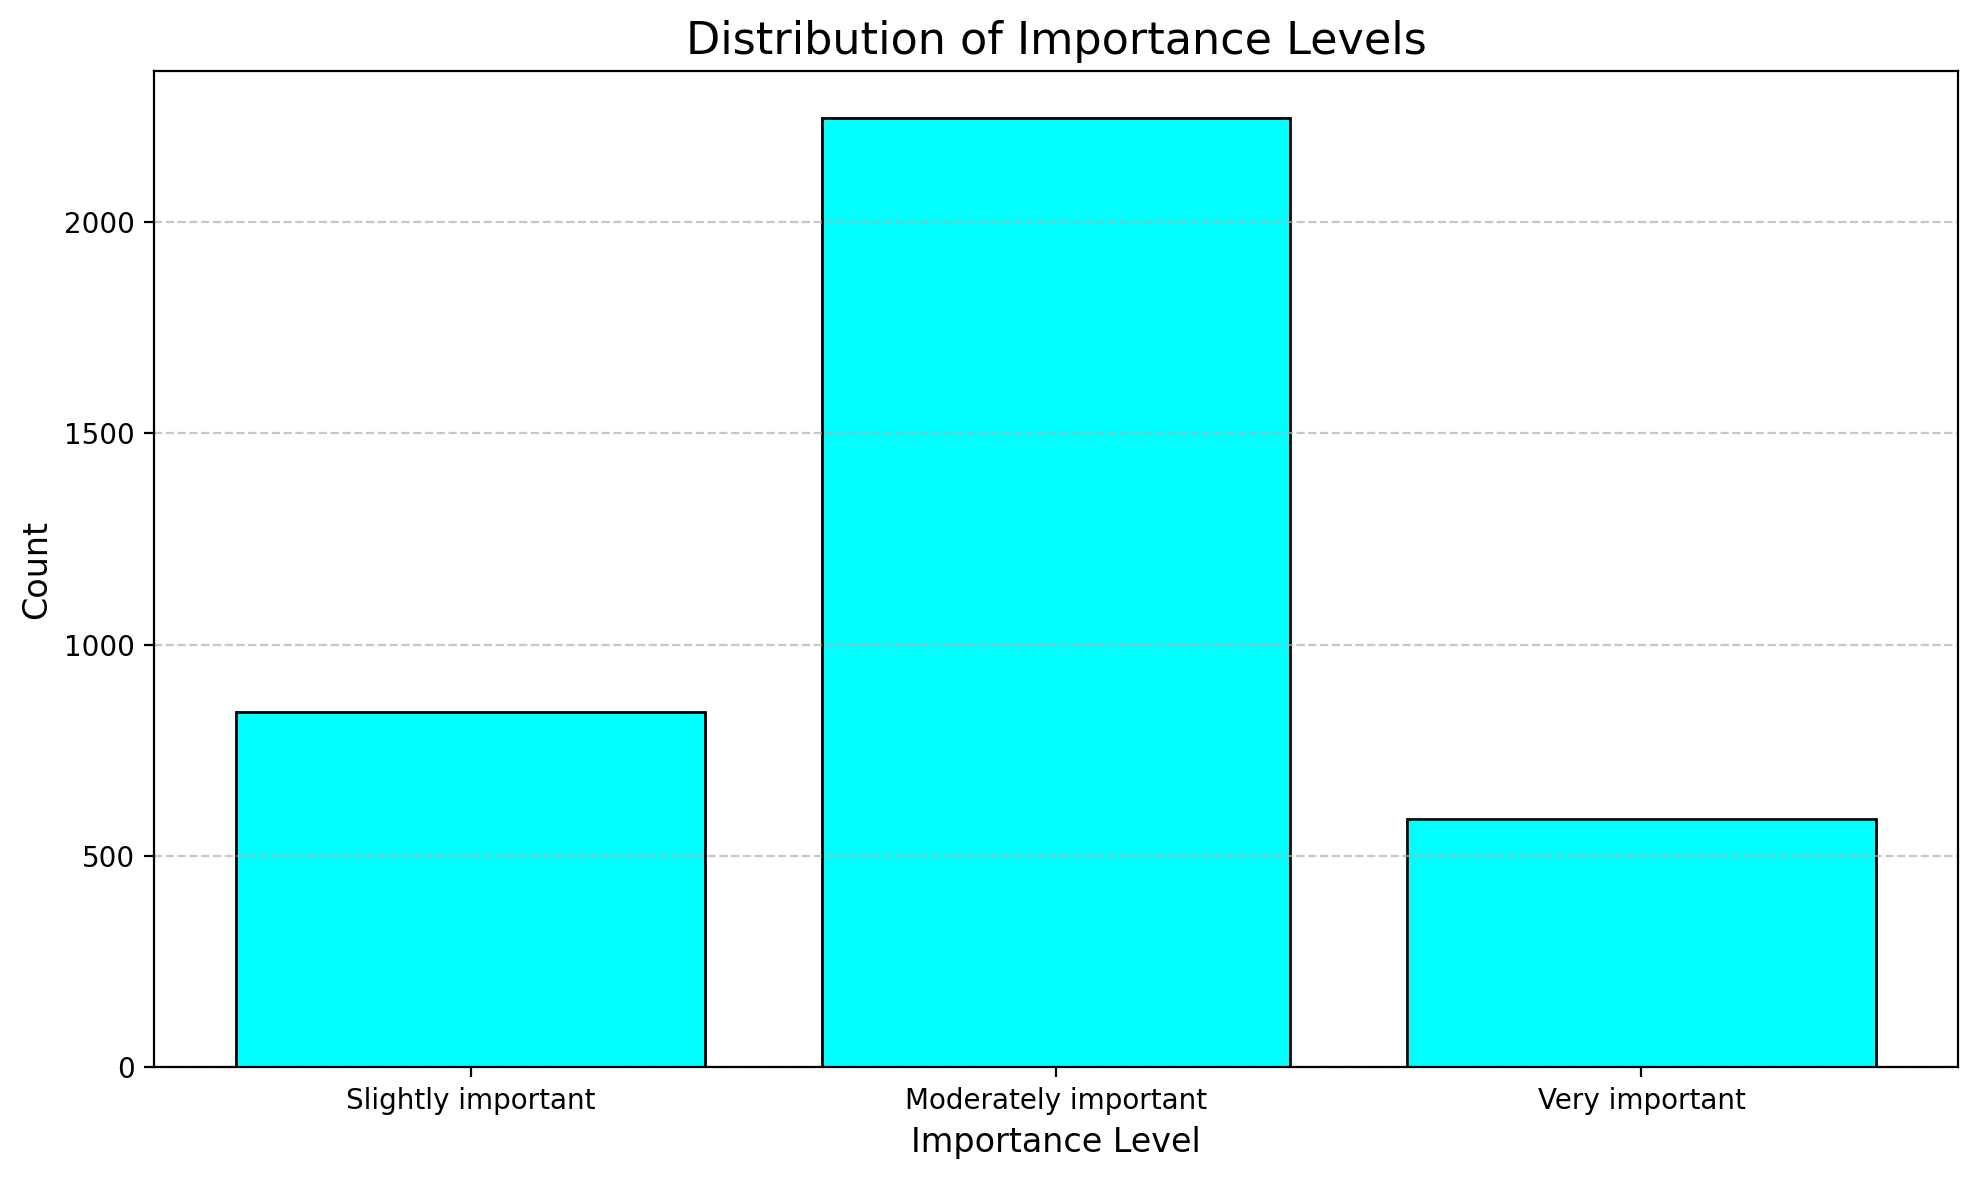

In [ ]:
import matplotlib.pyplot as plt

# Data for importance levels and their counts
importance_levels = ["Moderately important", "Slightly important", "Very important", "Not important", "Extremely important"]
counts = [2245, 807, 582, 33, 6]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(importance_levels, counts, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Importance Levels', fontsize=16)
plt.xlabel('Importance Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show the plot
plt.tight_layout()
plt.show()

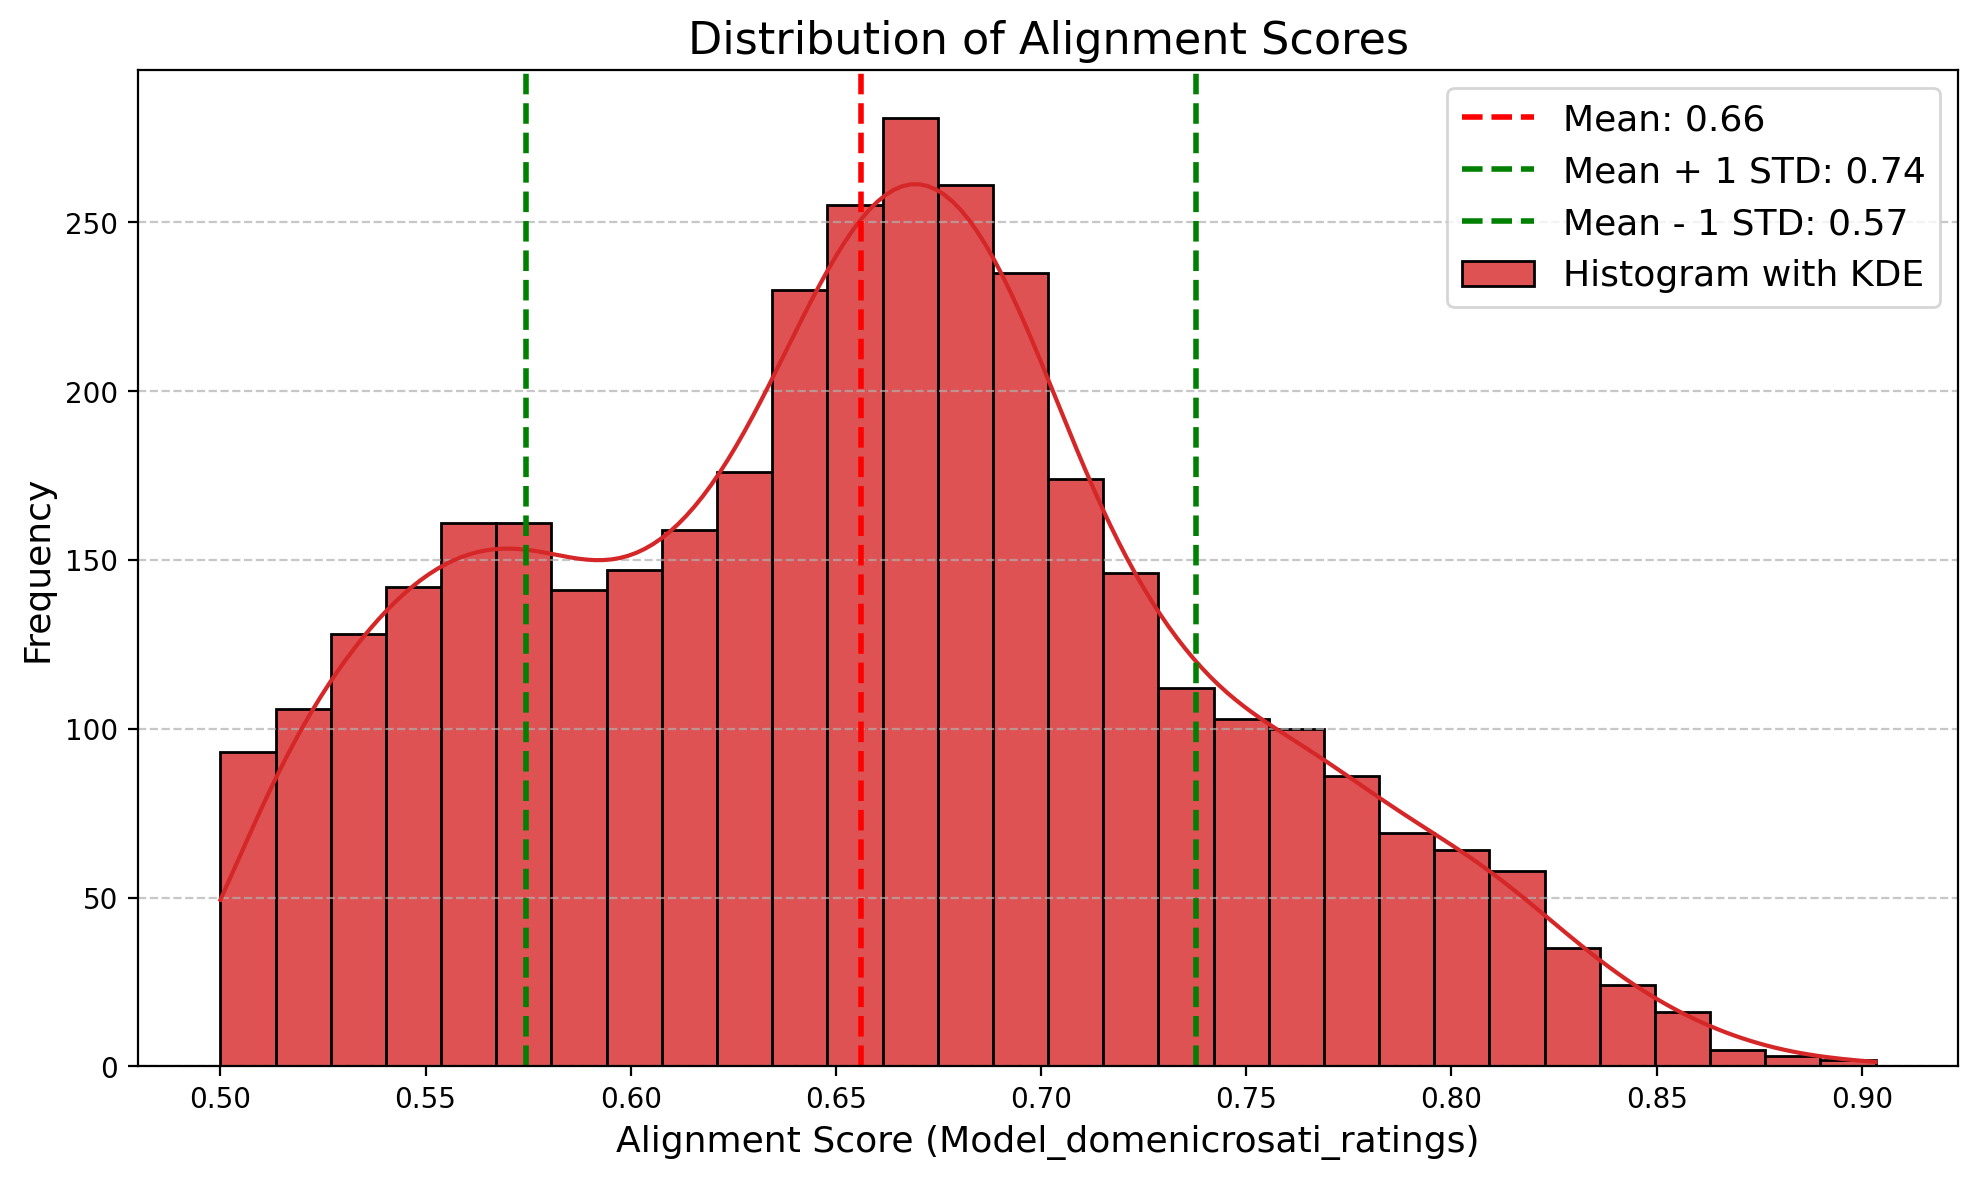

/var/folders/c1/0khxp9497hn1qlgvwr740t9m0000gn/T/ipykernel_13985/2368468952.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=importance_levels, y=alignment_scores, palette="Set2")


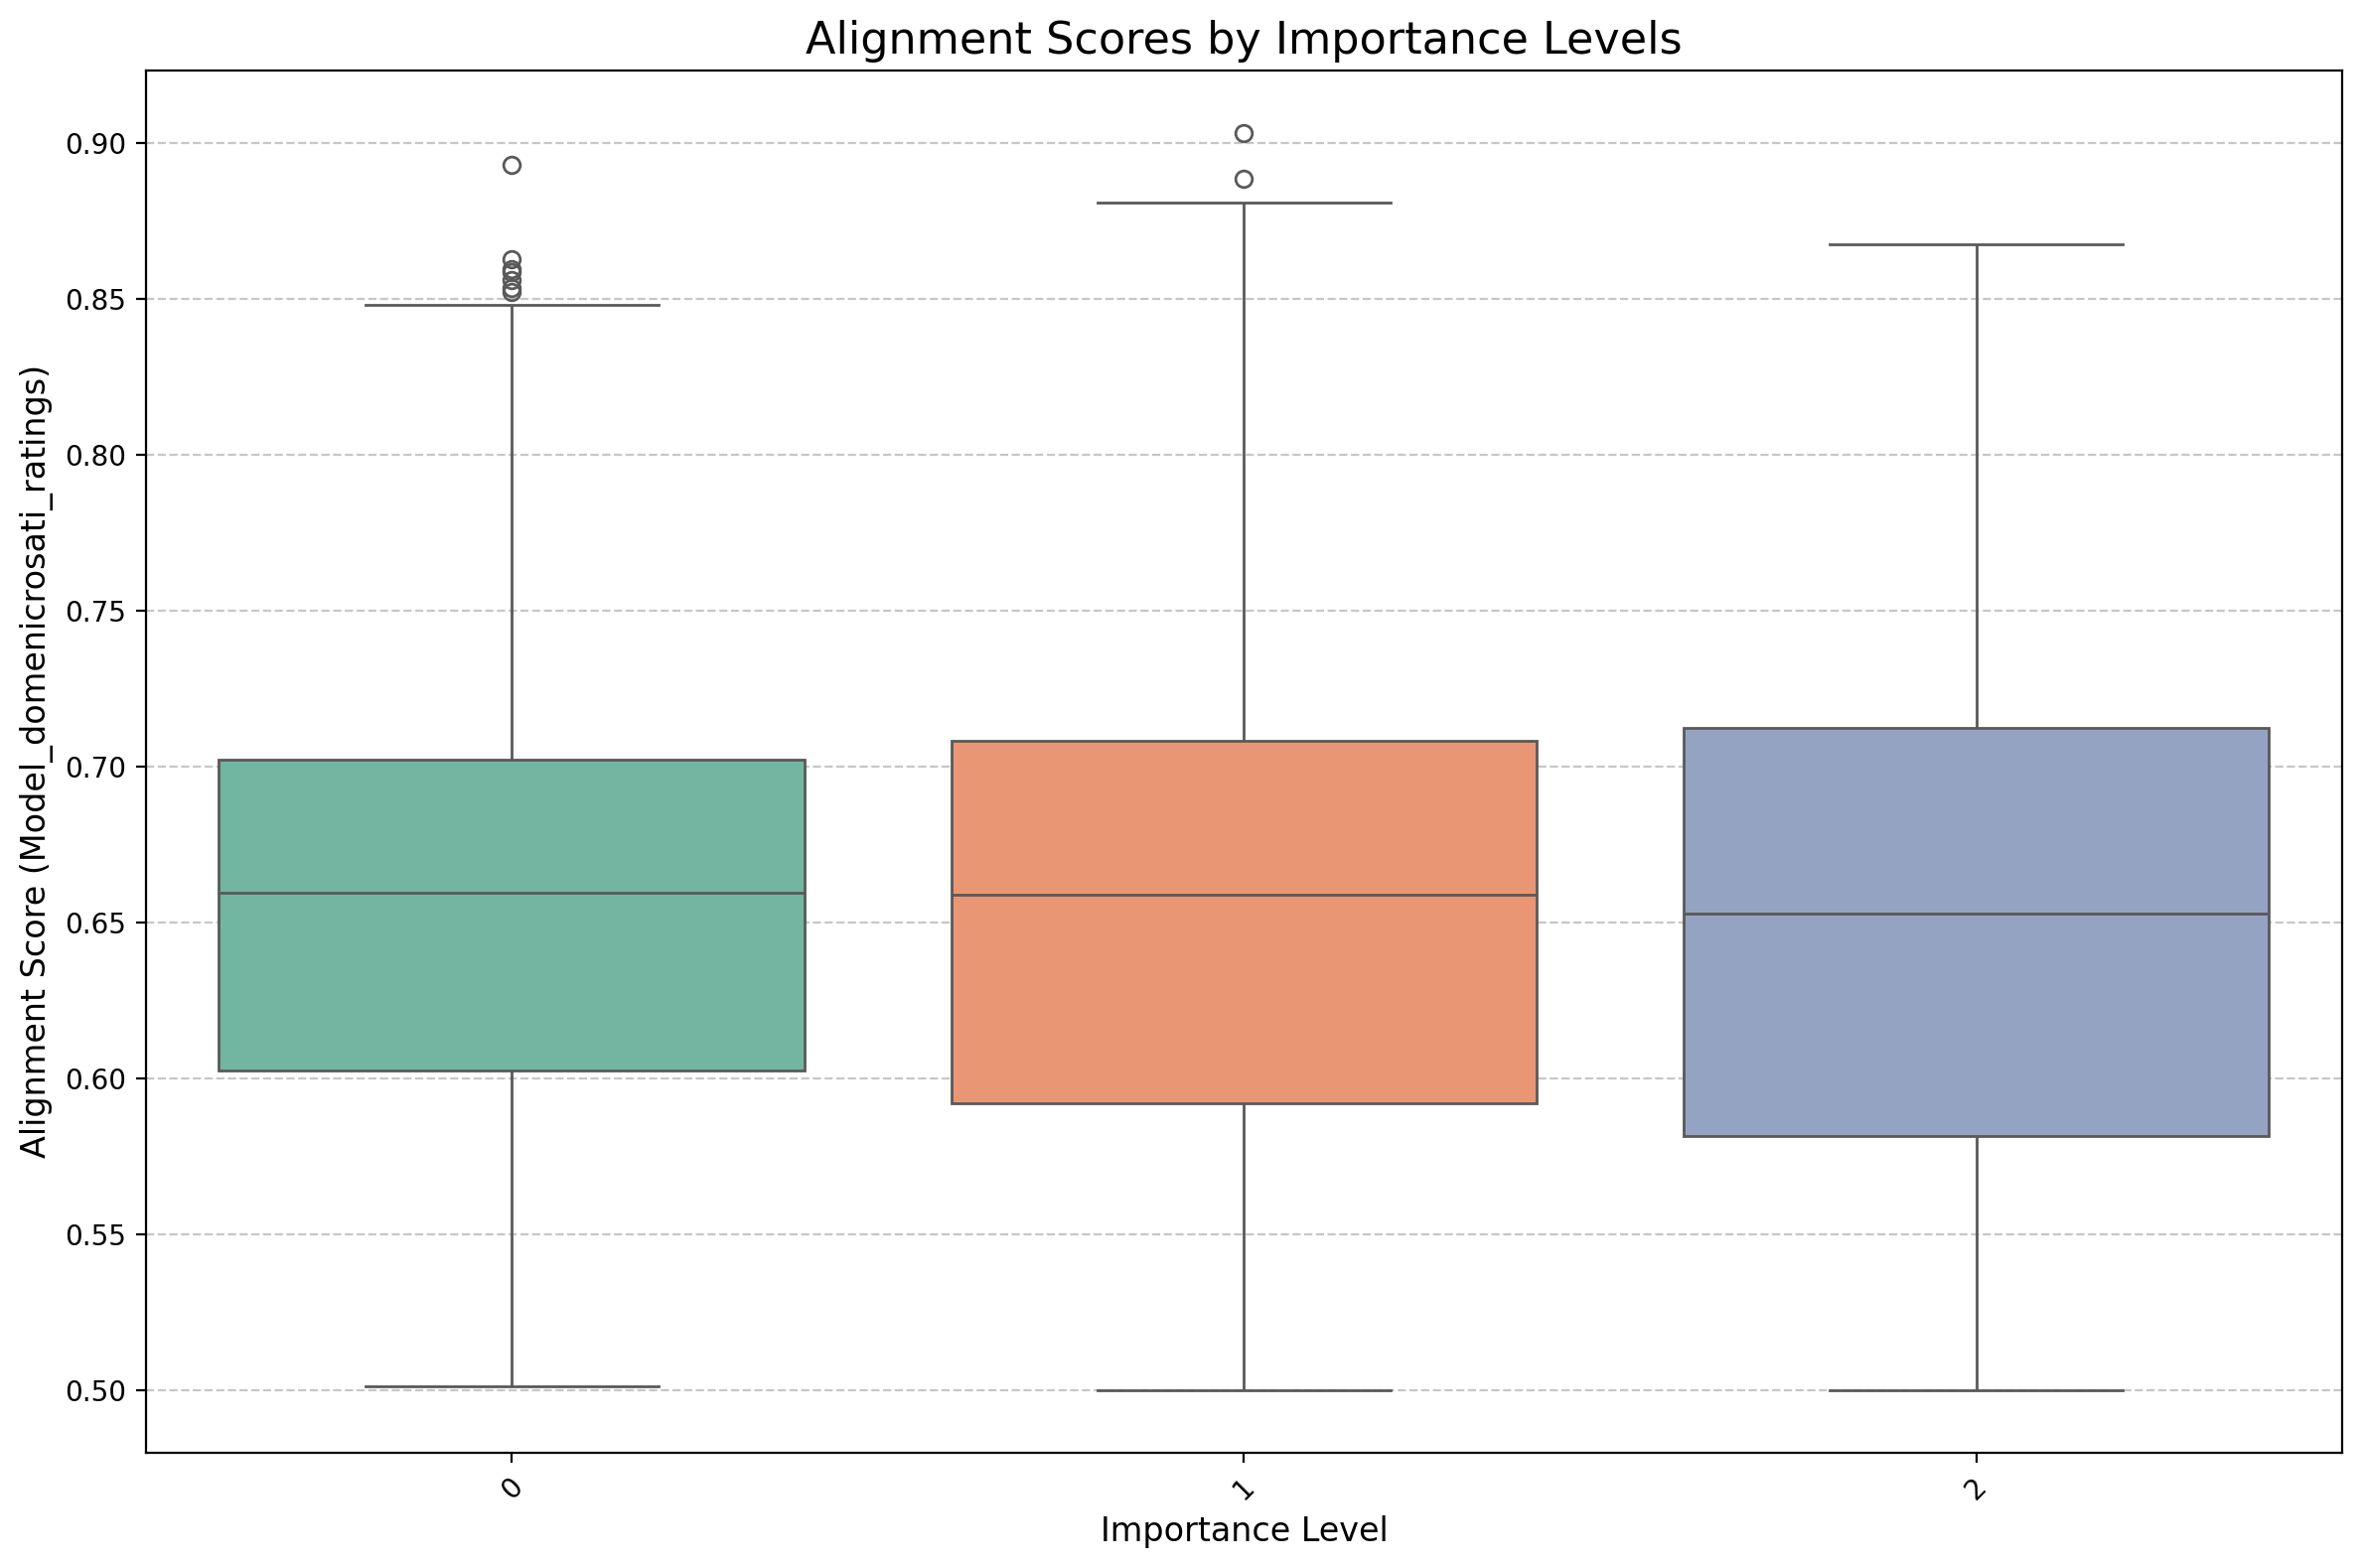

In [ ]:
# Simulating alignment scores (Model_domenicrosati_ratings)
alignment_scores = df_cleaned['Model_domenicrosati_ratings']

# Simulating corresponding importance levels
importance_categories = ["Moderately important", "Slightly important", "Very important"]
importance_levels = df_cleaned['LLM_GBT_4o_Human_Importance_Ratings']

# --- Visualization 1: Distribution of Alignment Scores with Mean, STD, and KDE --- #
plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(alignment_scores, bins=30, kde=True, color='C3', edgecolor='black', alpha=0.8, label="Histogram with KDE")

# Mean and STD lines
mean_score = np.mean(alignment_scores)
std_score = np.std(alignment_scores)

plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.2f}')
plt.axvline(mean_score + std_score, color='green', linestyle='--', linewidth=2, label=f'Mean + 1 STD: {mean_score + std_score:.2f}')
plt.axvline(mean_score - std_score, color='green', linestyle='--', linewidth=2, label=f'Mean - 1 STD: {mean_score - std_score:.2f}')

# Formatting
plt.title('Distribution of Alignment Scores', fontsize=16)
plt.xlabel('Alignment Score (Model_domenicrosati_ratings)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Visualization 2: Alignment Scores vs Importance Levels (Boxplot) --- #
plt.figure(figsize=(12, 8))
sns.boxplot(x=importance_levels, y=alignment_scores, palette="Set2")
plt.title('Alignment Scores by Importance Levels', fontsize=16)
plt.xlabel('Importance Level', fontsize=12)
plt.ylabel('Alignment Score (Model_domenicrosati_ratings)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
df.head()

,nct_id,Drug Name,conditions,Therapy Area,id,description,criteria,healthy_volunteers,adult,child,older_adult,Model_lloydmeta_Class,Model_lloydmeta_Score,Model_domenicrosati_ratings,Spacy Pregnant Women Excluded,Spacy2 Pregnant Women Excluded,LLama3_2_Criteria_Robustness,LLM_GBT_4o_Human_Importance_Ratings
0,NCT00000187,ritanserin,cocaine-related disorders,Toxicity/Intoxication; Neurology/Psychiatric,24095864,The purpose of this study is to assess ritanse...,Please contact site for information.,False,True,False,False,opiate withdrawal,0.831781,0.625245,No,No,0,Slightly important
1,NCT00000200,methadone,cocaine-related disorders,Neurology/Psychiatric,23965890,The purpose of this study is to compare the ef...,Please contact site for information.,False,True,False,False,opiate withdrawal,0.537430,0.662990,No,No,0,Moderately important
2,NCT00000395,methotrexate,rheumatoid arthritis,Immune; Dermatologic; Gastrointestinal; Ocular,24006623,This study looks at how the arthritis drug met...,Inclusion Criteria:~* Individuals starting met...,False,True,False,True,rheumatoid arthritis,0.999085,0.564219,No,No,0,Very important
3,NCT00000451,sertraline,alcoholism,Neurology/Psychiatric; Genitourinary/Sexual Fu...,23799489,This study will assess the ability of naltrexo...,Inclusion Criteria:~* Alaska Native having bio...,False,True,False,True,alcohol dependence,0.996837,0.575893,Yes,Yes,2,Moderately important
4,NCT00001723,orlistat,obesity,Other/Miscellaneous,24120128,Obesity is a condition affecting one-third off...,* INCLUSION CRITERIA:~Good general health. Ind...,False,False,True,False,obesity,0.999277,0.663715,Yes,Yes,2,Very important


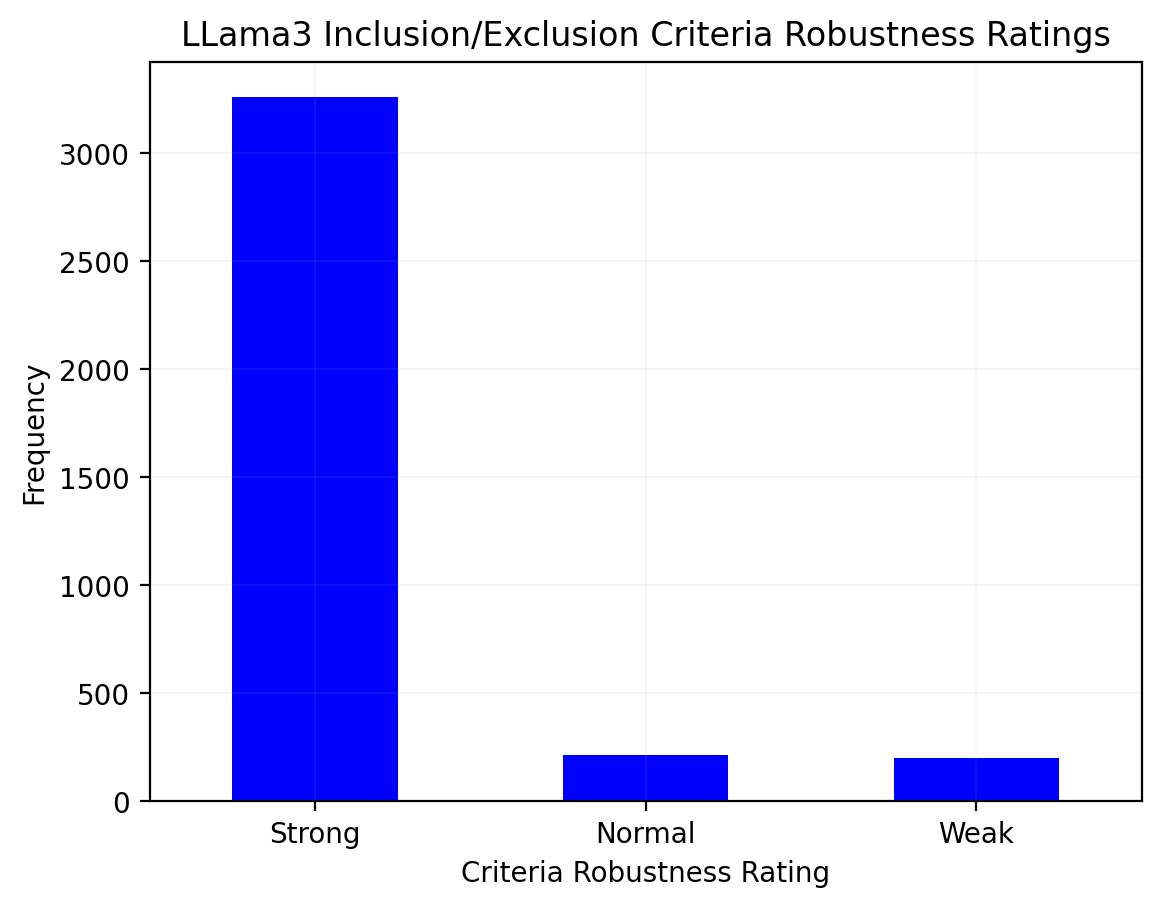

In [ ]:

# Map LLama3_2_Criteria_Robustness to "Weak", "Normal", "Strong" (including handling "Unknown" and "See website")
criteria_mapping_labels = {
    2: "Strong",
    1: "Normal",
    0: "Weak",
    0: "Weak",
}
df['Criteria_Robustness_Labeled'] = df['LLama3_2_Criteria_Robustness'].replace(criteria_mapping_labels)

# Barplot for Criteria Robustness with labels
plt.figure()
robustness_counts_labels = df['Criteria_Robustness_Labeled'].value_counts()
robustness_counts_labels.plot(kind='bar', color='blue')
plt.title("LLama3 Inclusion/Exclusion Criteria Robustness Ratings")
plt.xlabel("Criteria Robustness Rating")
plt.ylabel("Frequency")
plt.grid(alpha=0.1)
plt.xticks(rotation=0)
plt.show()

caption_llama3 = """
Figure: Distribution of criteria robustness ratings from the LLama3 model.
'Unknown' values are mapped to 'Weak' based on the justification that a lack of specific clarity in criteria
can be interpreted as weak robustness. This categorization ensures a more interpretable dataset for evaluation purposes.
"""

/var/folders/c1/0khxp9497hn1qlgvwr740t9m0000gn/T/ipykernel_13985/3042981459.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(index, value + 5, f"{pregnancy_exclusion_percentages[index]:.1f}%", ha='center')


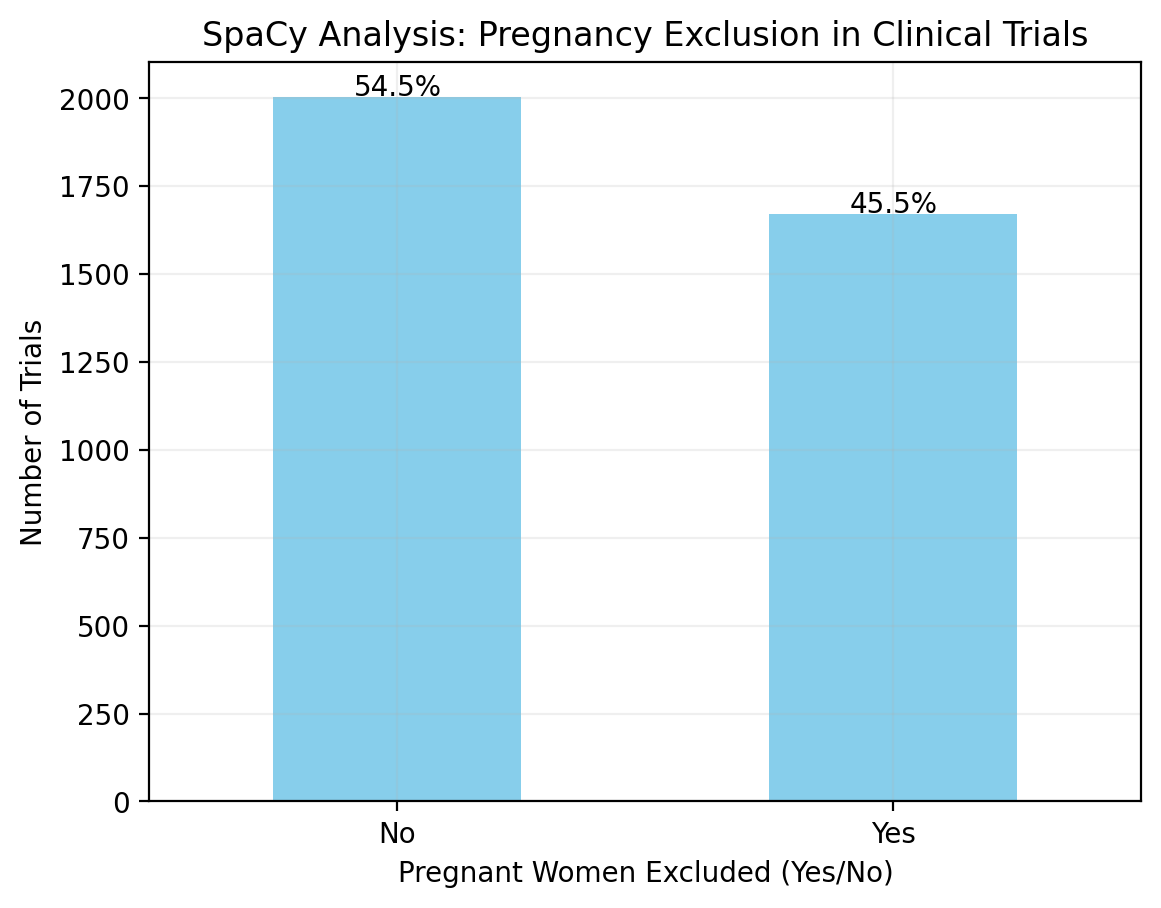

In [ ]:
# Calculate percentages for pregnancy exclusion
pregnancy_exclusion_percentages = (
    df['Spacy Pregnant Women Excluded'].value_counts(normalize=True) * 100
)

# Bar chart with percentages displayed
plt.figure()
pregnancy_exclusion_counts.plot(kind='bar', color='skyblue')
for index, value in enumerate(pregnancy_exclusion_counts):
    plt.text(index, value + 5, f"{pregnancy_exclusion_percentages[index]:.1f}%", ha='center')

plt.title("SpaCy Analysis: Pregnancy Exclusion in Clinical Trials")
plt.xlabel("Pregnant Women Excluded (Yes/No)")
plt.ylabel("Number of Trials")
plt.xticks(rotation=0)
plt.grid(alpha=0.2)
plt.show()